## Part 1 Getting Started with LogitLens

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

import matplotlib.pyplot as plt
import numpy as np

import plotly.express as px
import plotly.io as pio

import pandas as pd
import seaborn as sns


### 1.1: Implement LogitLens

In [2]:
def run_logitlens(model, tokenizer, prompt, top_k, device):
    #token -> tensor
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    #forward pass to get all hidden states
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.hidden_states

    W_U = model.lm_head.weight
    try:
        final_norm = model.transformer.ln_f        # GPT-2
    except:
        final_norm = model.model.norm             # Qwen

    results = []
    layer_logits = []

    for layer_idx in range(1, len(hidden_states)):
        h = hidden_states[layer_idx][0, -1]
        h_norm = final_norm(h)

        logits = torch.matmul(W_U, h_norm)
        layer_logits.append(logits.cpu())

        probs = torch.softmax(logits, dim=-1)
        top_probs, top_indices = torch.topk(probs, k=top_k)
        top_tokens = [tokenizer.decode([i.item()]) for i in top_indices]

        results.append({
            "layer": layer_idx,
            "tokens": top_tokens,
            "probs": top_probs.cpu().tolist()
        })

    return results, layer_logits


In [3]:
def print_logitlens_results(results, prompt):
    print(f"\nPrompt: {prompt}\n")
    for r in results:
        layer = r["layer"]
        toks = r["tokens"]
        probs = r["probs"]

        pretty = [f"{tok.strip() or repr(tok)} ({p:.3f})"
                  for tok, p in zip(toks, probs)]
        print(f"Layer {layer:2d}: " + " | ".join(pretty))


In [4]:
def plot_token_curve(tokenizer, target_token, layer_logits):
    token_id = tokenizer.encode(target_token, add_special_tokens=False)[0]

    probs = []

    for logits in layer_logits:
        logits = logits.squeeze()
        softmax_probs = torch.softmax(logits, dim=-1)
        probs.append(softmax_probs[token_id].item())

    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(layer_logits)+1), probs, marker='o')
    plt.title(f"Probability of token '{target_token}' across layers")
    plt.xlabel("Layer")
    plt.ylabel("Probability")
    plt.grid(True)
    plt.show()

    return probs

In [5]:
def heatmap_matrix(results, top_k=10):
    num_layers = len(results)

    token_matrix = np.empty((num_layers, top_k), dtype=object)
    prob_matrix = np.zeros((num_layers, top_k))

    for row, layer_info in enumerate(results):
        toks = layer_info["tokens"][:top_k]
        probs = layer_info["probs"][:top_k]

        for col in range(top_k):
            token_matrix[row, col] = toks[col]
            prob_matrix[row, col] = probs[col]

    return token_matrix, prob_matrix

In [6]:
def plot_heatmap(token_matrix, prob_matrix):
    num_layers, top_k = prob_matrix.shape

    fig = px.imshow(
        prob_matrix,
        x=[f"{i+1}" for i in range(top_k)],
        y=list(range(num_layers)),
        color_continuous_scale=px.colors.diverging.RdYlBu_r,
        color_continuous_midpoint=0.5,
        text_auto=True,
        labels=dict(x="Rank", y="Layer", color="Probability")
    )

    fig.update_traces(text=token_matrix, texttemplate="%{text}")
    fig.update_layout(
        title="LogitLens Heatmap",
        xaxis_tickangle=0
    )
    fig.show()


In [7]:
# load model GPT2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "gpt2"
topk = 5
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    output_hidden_states = True
    ).to(DEVICE).eval()

print(MODEL_NAME + " model loaded!")

#logit lens
prompt = "The Eiffel Tower is in the city of"
results, layer_logits = run_logitlens(model, tokenizer, prompt, top_k=topk, device=DEVICE)
print_logitlens_results(results, prompt)
token_matrix, prob_matrix = heatmap_matrix(results, top_k=topk)
plot_heatmap(token_matrix, prob_matrix)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


gpt2 model loaded!

Prompt: The Eiffel Tower is in the city of

Layer  1: the (0.690) | course (0.053) | a (0.031) | his (0.007) | ' (0.007)
Layer  2: the (0.813) | course (0.053) | a (0.017) | its (0.007) | late (0.004)
Layer  3: the (0.720) | course (0.128) | a (0.022) | its (0.006) | late (0.005)
Layer  4: the (0.688) | course (0.065) | a (0.013) | his (0.007) | Ar (0.006)
Layer  5: the (0.414) | course (0.085) | Z (0.022) | La (0.022) | Ar (0.018)
Layer  6: the (0.058) | England (0.053) | course (0.042) | Mir (0.033) | Ar (0.030)
Layer  7: East (0.057) | England (0.045) | southwest (0.039) | south (0.035) | La (0.034)
Layer  8: Ing (0.136) | Rome (0.081) | La (0.049) | Naples (0.036) | San (0.030)
Layer  9: Rome (0.192) | London (0.060) | Chicago (0.054) | San (0.046) | La (0.046)
Layer 10: London (0.285) | Paris (0.248) | Amsterdam (0.088) | Rome (0.039) | Chicago (0.031)
Layer 11: Paris (0.183) | London (0.175) | Amsterdam (0.080) | Berlin (0.053) | Hamburg (0.033)
Layer 12: the 

y-axis: each layer; x-axis: top-k slot; cell content: the k-th ranked token at that layer; color: iprobability.

- Why does the probability of the correct token decrease again in the final layers?
- Why are the probabilities in the early layers almost all zero?

Observation：
- Layers 0–4: The model predicts mostly function words like “the”, showing only shallow syntactic processing.

- Layers 5–7: Geographic-related tokens emerge (England, Rome, Naples), indicating activation of the semantic region related to cities.

- Layers 8–10: The model converges toward the correct answer. Rome appears first, then London and finally Paris, which becomes the top prediction in Layer 11.

- Layer 11: The model shifts back toward generic high-frequency tokens, as the last layer is optimized for next-token prediction rather than knowledge retrieval.

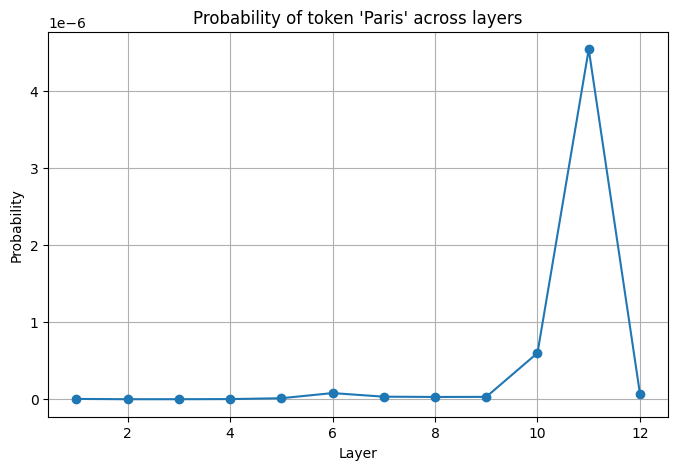

[4.593218694282086e-09,
 5.101456479472688e-10,
 7.124482670484156e-10,
 2.3261350623471344e-09,
 1.3405950127776123e-08,
 8.017381958325132e-08,
 3.353043709353187e-08,
 2.9868218121009704e-08,
 3.101889234358168e-08,
 6.001022256896249e-07,
 4.538783286989201e-06,
 7.040128480184649e-08]

In [8]:
plot_token_curve(tokenizer, "Paris", layer_logits)

### 1.2: LogitLens on Multilingual Models
model choice: Qwen1.5-0.5B

In [9]:
MODEL_NAME = "Qwen/Qwen1.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    output_hidden_states=True,
).to(DEVICE).eval()
print(MODEL_NAME + " model loaded!")

prompt = "La tour Eiffel se trouve dans la ville de"
results, layer_logits = run_logitlens(model, tokenizer, prompt, top_k=topk, device=DEVICE)
print_logitlens_results(results, prompt)
token_matrix, prob_matrix = heatmap_matrix(results, top_k=topk)
plot_heatmap(token_matrix, prob_matrix)

Qwen/Qwen1.5-0.5B model loaded!

Prompt: La tour Eiffel se trouve dans la ville de

Layer  1: 麟 (0.023) | iphy (0.019) | 趵 (0.016) | 山村 (0.013) | precation (0.011)
Layer  2: 的感受 (0.018) | № (0.014) | precation (0.012) | (da (0.011) | '\n                        \n' (0.007)
Layer  3: icina (0.038) | puties (0.013) | ixo (0.011) | pute (0.010) | 产出 (0.007)
Layer  4: icina (0.053) | � (0.026) | puties (0.021) | pute (0.016) | ('.')[ (0.013)
Layer  5: ('/')[ (0.076) | ('.')[ (0.066) | pute (0.052) | :", (0.021) | であれば (0.020)
Layer  6: atrib (0.026) | mình (0.025) | :", (0.025) | 鞣 (0.024) | pute (0.020)
Layer  7: mình (0.106) | >" (0.041) | ): (0.037) | :", (0.031) | \""; (0.027)
Layer  8: >" (0.071) | \""; (0.053) | 辂 (0.039) | 邠 (0.022) | � (0.018)
Layer  9: 辂 (0.147) | ...', (0.039) | ): (0.035) | *) (0.022) | }); (0.019)
Layer 10: icode (0.046) | 辂 (0.039) | }); (0.029) | ჭ (0.024) | *) (0.019)
Layer 11: 辂 (0.049) | \AppData (0.028) | ...', (0.027) | 澍 (0.020) | :'; (0.018)
Layer 12: 辂

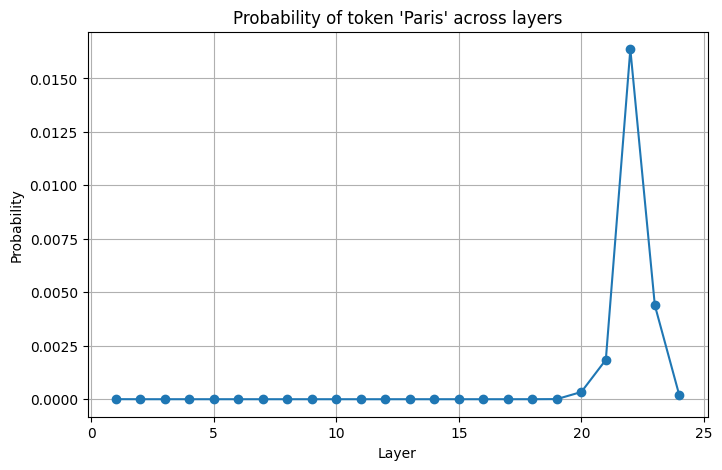

[2.2807575987826567e-06,
 1.8811118707162677e-07,
 2.1300445496308384e-07,
 1.3349794869554898e-07,
 3.676740467639661e-09,
 2.6243208495202452e-08,
 9.534527833920947e-09,
 2.4116809882457346e-08,
 2.2633441787434094e-09,
 1.6946299918885188e-09,
 7.092197051861149e-09,
 1.8188648365224935e-09,
 2.6276616438281053e-09,
 9.330915595739953e-09,
 4.33561719859199e-09,
 1.4352711019682829e-08,
 6.680332376163278e-08,
 8.745199124859937e-07,
 5.444619091576897e-06,
 0.0003377287066541612,
 0.001842369674704969,
 0.01636381261050701,
 0.004391332622617483,
 0.00017838954227045178]

In [10]:
plot_token_curve(tokenizer, "Paris", layer_logits)

GPT-2 starts to show “Paris” in the middle layers (around layers 10–11), while Qwen1.5-0.5B only shows a strong “Paris” signal very late (around layers 20–23). Both models suggest that factual knowledge appears mainly in the last few layers, and the final layer is not always the best one for predicting the correct answer.

- Why does model Qwen produce so many strange or garbled tokens in the middle layers?

## Part 2: Cross-Lingual Exploration

### 2.1: Brainstorming
- Dimensions of multilinguality:can test the same prompt in different languages; different languages may cause the model to encode the same fact in different ways.

- Do different languages or word orders cause different layers to activate different tokens?

- Does the model first map different characters/languages into a shared semantic space? (for example, an English-like space)

- Do different prompt types behave differently — e.g., questions vs. statements?

### 2.2: Experiments
**Experiment 1: LogitLens comparison of the same fact across different languages**

For the prompt:
“The Eiffel Tower is in the city of”

Translate it into multiple languages:English, French, Chinese, Japanese and Spanish

Then compare the LogitLens activations for each language.



---


**Experiment 2: Mixed-language prompts (testing “internal translation / English interference”)**

Examples:

- La tour Eiffel is in the city of (French + English mixed)

- 埃菲尔铁塔 is in the city of

- The Eiffel Tower 位于城市

- La tour Eiffel 位于城市

In [11]:
MODEL_NAME = "Qwen/Qwen1.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    output_hidden_states=True,
).to(DEVICE).eval()
print(MODEL_NAME + " model loaded!")

Qwen/Qwen1.5-0.5B model loaded!


In [12]:
# Experiment 1: Multilingual Prompts
prompts_multilingual = {
    "English": "The Eiffel Tower is in the city of",
    "French": "La tour Eiffel se trouve dans la ville de",
    "Chinese": "埃菲尔铁塔位于城市",
    "Spanish": "La torre Eiffel está en la ciudad de",
    "Japanese": "エッフェル塔は都市にあります"
}

for lang, prompt in prompts_multilingual.items():
    print(f"\n\n==============================")
    print(f"Running LogitLens for language: {lang}")
    print(f"Prompt: {prompt}")
    print(f"==============================\n")

    # Run LogitLens
    results, layer_logits = run_logitlens(
        model, tokenizer, prompt, top_k=5, device=DEVICE
    )

    # Print tokens
    print_logitlens_results(results, prompt)

    # Heatmap
    token_matrix, prob_matrix = heatmap_matrix(results, top_k=5)
    plot_heatmap(token_matrix, prob_matrix)

    print("\nExperiment for", lang, "completed.")




Running LogitLens for language: English
Prompt: The Eiffel Tower is in the city of


Prompt: The Eiffel Tower is in the city of

Layer  1: course (0.486) | -course (0.130) | course (0.047) | erta (0.041) | sorts (0.025)
Layer  2: course (0.166) | course (0.045) | -course (0.037) | !!"); (0.026) | ecute (0.020)
Layer  3: course (0.049) | ertas (0.039) | course (0.028) | !"); (0.027) | !!"); (0.023)
Layer  4: !"); (0.088) | ?"; (0.088) | !!"); (0.056) | � (0.048) | :'; (0.043)
Layer  5: :'; (0.143) | ' (0.045) | :'); (0.036) | 术 (0.032) | 颔 (0.029)
Layer  6: :: (0.142) | '; (0.069) | :'; (0.066) | ?"; (0.043) | � (0.037)
Layer  7: :'; (0.060) | ?"; (0.058) | \""; (0.046) | ...', (0.037) | � (0.034)
Layer  8: \""; (0.030) | ...', (0.028) | ?"; (0.027) | ?"; (0.023) | 辂 (0.020)
Layer  9: ?"; (0.042) | ...', (0.034) | ...", (0.027) | emi (0.024) | \ (0.021)
Layer 10: :'; (0.100) | ?"; (0.048) | ...', (0.026) | ...", (0.016) | ."; (0.015)
Layer 11: ...', (0.064) | :'; (0.050) | './../../ (


Experiment for English completed.


Running LogitLens for language: French
Prompt: La tour Eiffel se trouve dans la ville de


Prompt: La tour Eiffel se trouve dans la ville de

Layer  1: 麟 (0.023) | iphy (0.019) | 趵 (0.016) | 山村 (0.013) | precation (0.011)
Layer  2: 的感受 (0.018) | № (0.014) | precation (0.012) | (da (0.011) | '\n                        \n' (0.007)
Layer  3: icina (0.038) | puties (0.013) | ixo (0.011) | pute (0.010) | 产出 (0.007)
Layer  4: icina (0.053) | � (0.026) | puties (0.021) | pute (0.016) | ('.')[ (0.013)
Layer  5: ('/')[ (0.076) | ('.')[ (0.066) | pute (0.052) | :", (0.021) | であれば (0.020)
Layer  6: atrib (0.026) | mình (0.025) | :", (0.025) | 鞣 (0.024) | pute (0.020)
Layer  7: mình (0.106) | >" (0.041) | ): (0.037) | :", (0.031) | \""; (0.027)
Layer  8: >" (0.071) | \""; (0.053) | 辂 (0.039) | 邠 (0.022) | � (0.018)
Layer  9: 辂 (0.147) | ...', (0.039) | ): (0.035) | *) (0.022) | }); (0.019)
Layer 10: icode (0.046) | 辂 (0.039) | }); (0.029) | ჭ (0.024) | *) (0.01


Experiment for French completed.


Running LogitLens for language: Chinese
Prompt: 埃菲尔铁塔位于城市


Prompt: 埃菲尔铁塔位于城市

Layer  1: 起码 (0.019) | 人民政府 (0.015) | 其他的 (0.013) | 的身份 (0.012) | intelig (0.010)
Layer  2: 化进程 (0.059) | 长效 (0.041) | 其他的 (0.041) | etta (0.033) | 隍 (0.019)
Layer  3: aug (0.064) | 化进程 (0.049) | 象征 (0.043) | etta (0.024) | mig (0.021)
Layer  4: 化进程 (0.193) | 隍 (0.052) | 另一位 (0.024) | 其他的 (0.022) | aug (0.017)
Layer  5: 化进程 (0.535) | scape (0.020) | 另一位 (0.017) | aug (0.015) | bàn (0.011)
Layer  6: 化进程 (0.753) | 另一位 (0.018) | midi (0.011) | eki (0.008) | scape (0.008)
Layer  7: 化进程 (0.775) | bàn (0.019) | marshaller (0.013) | scape (0.011) | 小伙 (0.007)
Layer  8: 化进程 (0.700) | bàn (0.087) | uco (0.020) | etta (0.013) | scape (0.011)
Layer  9: 化进程 (0.728) | bàn (0.024) | uco (0.017) | midi (0.013) | scape (0.012)
Layer 10: 化进程 (0.561) | bàn (0.027) | midi (0.019) | scape (0.011) | <dd (0.006)
Layer 11: 化进程 (0.247) | midi (0.089) | scape (0.077) | bàn (0.014) | QUARE (0.014)



Experiment for Chinese completed.


Running LogitLens for language: Spanish
Prompt: La torre Eiffel está en la ciudad de


Prompt: La torre Eiffel está en la ciudad de

Layer  1: 麟 (0.021) | 趵 (0.018) | iphy (0.016) | 嶙 (0.016) | 临床 (0.009)
Layer  2: 作风 (0.016) | 饸 (0.016) | iphy (0.015) | 医师 (0.012) | ycastle (0.011)
Layer  3: nces (0.034) | を持つ (0.033) | :", (0.015) | ated (0.012) | flate (0.012)
Layer  4: ated (0.021) | を持つ (0.017) | icina (0.015) | 嫁 (0.010) | ('.')[ (0.009)
Layer  5: :", (0.039) | pute (0.034) | 一开始就 (0.032) | を持つ (0.030) | ('.')[ (0.029)
Layer  6: окумент (0.027) | :", (0.023) | ' \n\t\t\n' (0.023) | />"; (0.023) | =''): (0.014)
Layer  7: :", (0.062) | oplay (0.032) | を持つ (0.027) | \ (0.024) | icode (0.024)
Layer  8: ldata (0.039) | icode (0.038) | ...', (0.033) | :'; (0.031) | oplay (0.026)
Layer  9: ...', (0.148) | icode (0.056) | ASTE (0.044) | \ (0.038) | となっている (0.018)
Layer 10: ...', (0.092) | icode (0.060) | ASTE (0.053) | :'; (0.040) | \AppData (0.021)
L


Experiment for Spanish completed.


Running LogitLens for language: Japanese
Prompt: エッフェル塔は都市にあります


Prompt: エッフェル塔は都市にあります

Layer  1: 两款 (0.169) | emi (0.060) | self (0.043) | 跖 (0.035) | bersome (0.020)
Layer  2: 两款 (0.081) | SES (0.063) | bersome (0.048) | self (0.025) | emi (0.024)
Layer  3: 两款 (0.069) | emi (0.059) | bersome (0.033) | 阒 (0.025) | 笠 (0.018)
Layer  4: 查看更多 (0.029) | .': (0.027) | bersome (0.014) | 娈 (0.011) | (fig (0.009)
Layer  5: 查看更多 (0.033) | <TextView (0.028) | <path (0.025) | bersome (0.022) | adows (0.018)
Layer  6: 查看更多 (0.047) | <path (0.045) | 结构性 (0.037) | <TextView (0.029) | 诮 (0.026)
Layer  7: 查看更多 (0.093) | vertisement (0.051) | <path (0.044) | ollapsed (0.018) | 法定代表 (0.016)
Layer  8: vertisement (0.054) | ollapsed (0.036) | /browse (0.031) | 结构性 (0.025) | <path (0.024)
Layer  9: /browse (0.070) | か (0.053) | vertisement (0.047) | 查看更多 (0.032) | 诮 (0.026)
Layer 10: 恸 (0.158) | /browse (0.031) | aan (0.020) | ?', (0.017) | か (0.011)
Layer 11: /browse


Experiment for Japanese completed.


**Analysis**

- English: Layers 1–10 mostly produce gibberish or meaningless tokens. Around layers 18–20, city-related concepts begin to appear. From layer 21 onward, the model strongly activates “Paris.”
- French: The internal processing path is very similar to English: noisy lower layers, cross-lingual tokens emerging in the middle layers, and stable retrieval of “Paris” in the highest layers.
- Spanish: Middle layers still contain noise, but city-related semantics appear after layer 20. Layers 21–24 produce “Paris / 巴黎 / paris” reliably, though slightly weaker than English/French.
- Chinese: Middle layers show location-related tokens such as “城区”, “中心”, and “地方.” A tendency toward city names appears only around layer 20. Layers 21–24 consistently activate “巴黎 / Paris.”
- Japanese: The only language where the model completely fails to retrieve “Eiffel Tower → Paris.” All layers remain dominated by fragmented Japanese tokens and noise, indicating very weak factual retrieval in Japanese.

**Summary:**

Except for Japanese, all languages eventually activate “Paris” in the higher layers (~21+).

However, the activation depth and strength vary: English/French are the most stable, Spanish/Chinese weaker but still successful, and Japanese fails entirely.

In [13]:
#Experiment 2: Mixed-Language Prompts

prompts_mixed = {
    "French-English": "La tour Eiffel is in the city of",
    "Chinese-English": "埃菲尔铁塔 is in the city of",
    "English-Chinese": "The Eiffel Tower 位于城市",
    "French-Chinese": "La tour Eiffel 位于城市"
}

for mix, prompt in prompts_mixed.items():
    print(f"\n\n==============================")
    print(f"Running Mixed-Language LogitLens: {mix}")
    print(f"Prompt: {prompt}")
    print(f"==============================\n")

    # Run LogitLens
    results, layer_logits = run_logitlens(
        model, tokenizer, prompt, top_k=5, device=DEVICE
    )

    # Print results
    print_logitlens_results(results, prompt)

    # Heatmap
    token_matrix, prob_matrix = heatmap_matrix(results, top_k=5)
    plot_heatmap(token_matrix, prob_matrix)

    print("\nExperiment", mix, "completed.")




Running Mixed-Language LogitLens: French-English
Prompt: La tour Eiffel is in the city of


Prompt: La tour Eiffel is in the city of

Layer  1: course (0.439) | -course (0.127) | erta (0.059) | course (0.045) | sorts (0.025)
Layer  2: course (0.131) | course (0.034) | -course (0.030) | ecute (0.024) | !!"); (0.023)
Layer  3: ertas (0.048) | course (0.033) | !"); (0.024) | ecute (0.023) | !!"); (0.021)
Layer  4: !"); (0.102) | ?"; (0.079) | !!"); (0.059) | :'; (0.058) | � (0.029)
Layer  5: :'; (0.132) | ' (0.047) | 术 (0.036) | ...", (0.032) | :'); (0.029)
Layer  6: :: (0.158) | '; (0.047) | :'; (0.046) | � (0.033) | tablet (0.020)
Layer  7: ...', (0.039) | :'; (0.034) | ?"; (0.032) | ...", (0.029) | elu (0.028)
Layer  8: ...', (0.038) | \""; (0.032) | ='') (0.026) | 高潮 (0.016) | lc (0.015)
Layer  9: ?"; (0.033) | ...', (0.026) | \ (0.022) | emi (0.022) | ldata (0.019)
Layer 10: :'; (0.116) | ?"; (0.041) | ...', (0.024) | \"", (0.015) | \AppData (0.015)
Layer 11: :'; (0.049) | './../..


Experiment French-English completed.


Running Mixed-Language LogitLens: Chinese-English
Prompt: 埃菲尔铁塔 is in the city of


Prompt: 埃菲尔铁塔 is in the city of

Layer  1: course (0.471) | -course (0.126) | course (0.043) | erta (0.029) | sorts (0.020)
Layer  2: course (0.071) | course (0.031) | -course (0.028) | !!"); (0.026) | !"); (0.019)
Layer  3: ertas (0.065) | !"); (0.030) | !!"); (0.029) | course (0.022) | 庄村 (0.021)
Layer  4: ?"; (0.121) | !"); (0.082) | !!"); (0.079) | � (0.063) | :'; (0.030)
Layer  5: :'; (0.061) | ' (0.037) | ocur (0.023) | 颔 (0.022) | ...", (0.022)
Layer  6: :: (0.152) | :'; (0.066) | ?"; (0.041) | '; (0.030) | aug (0.022)
Layer  7: ...", (0.047) | ?"; (0.043) | :'; (0.038) | \""; (0.035) | � (0.033)
Layer  8: 辂 (0.061) | ...', (0.033) | \""; (0.029) | ='') (0.015) | ?"; (0.015)
Layer  9: ...', (0.069) | ?"; (0.052) | 畋 (0.039) | ...", (0.033) | emi (0.016)
Layer 10: ?"; (0.098) | ...', (0.062) | :'; (0.055) | 啭 (0.030) | ...", (0.017)
Layer 11: ...', (0.087) |


Experiment Chinese-English completed.


Running Mixed-Language LogitLens: English-Chinese
Prompt: The Eiffel Tower 位于城市


Prompt: The Eiffel Tower 位于城市

Layer  1: 起码 (0.021) | waking (0.017) | 其他的 (0.015) | 有不少 (0.013) | 的身份 (0.012)
Layer  2: 化进程 (0.067) | 长效 (0.031) | 级别的 (0.030) | 的身份 (0.017) | izedName (0.017)
Layer  3: aug (0.084) | 化进程 (0.073) | mig (0.023) | 象征 (0.017) | 风格 (0.017)
Layer  4: 化进程 (0.187) | scape (0.035) | vida (0.034) | aug (0.025) | 隍 (0.020)
Layer  5: 化进程 (0.304) | scape (0.027) | aug (0.026) | bàn (0.023) | 另一位 (0.020)
Layer  6: 化进程 (0.748) | marshaller (0.016) | 另一位 (0.015) | bàn (0.012) | midi (0.011)
Layer  7: 化进程 (0.880) | marshaller (0.016) | bàn (0.011) | scape (0.003) | uco (0.003)
Layer  8: 化进程 (0.743) | bàn (0.039) | midi (0.011) | 间的 (0.008) | etta (0.006)
Layer  9: 化进程 (0.632) | \">" (0.028) | \AppData (0.018) | midi (0.015) | bàn (0.010)
Layer 10: 化进程 (0.595) | midi (0.027) | bàn (0.022) | \">" (0.008) | 颙 (0.007)
Layer 11: 化进程 (0.155) | midi (0.07


Experiment English-Chinese completed.


Running Mixed-Language LogitLens: French-Chinese
Prompt: La tour Eiffel 位于城市


Prompt: La tour Eiffel 位于城市

Layer  1: 起码 (0.023) | 其他的 (0.018) | 有不少 (0.014) | 的身份 (0.012) | 之声 (0.011)
Layer  2: 化进程 (0.116) | etta (0.036) | 长效 (0.025) | izedName (0.016) | scape (0.016)
Layer  3: 化进程 (0.129) | aug (0.040) | scape (0.020) | mig (0.020) | 象征 (0.019)
Layer  4: 化进程 (0.173) | scape (0.055) | vida (0.032) | 隍 (0.020) | aug (0.015)
Layer  5: 化进程 (0.207) | scape (0.042) | bàn (0.030) | aug (0.020) | midi (0.018)
Layer  6: 化进程 (0.740) | marshaller (0.017) | scape (0.015) | bàn (0.013) | eki (0.008)
Layer  7: 化进程 (0.797) | marshaller (0.021) | bàn (0.014) | scape (0.007) | 风格 (0.006)
Layer  8: 化进程 (0.583) | bàn (0.101) | midi (0.020) | dài (0.014) | uco (0.009)
Layer  9: 化进程 (0.580) | midi (0.057) | \AppData (0.026) | почт (0.014) | scape (0.012)
Layer 10: 化进程 (0.445) | midi (0.065) | 颙 (0.040) | bàn (0.017) | <dd (0.012)
Layer 11: 化进程 (0.154) | midi (0.103


Experiment French-Chinese completed.


**Analysis**

- French–English: Strong high-layer activation of “Paris” (0.8+) almost identical to the monolingual case → the most stable mixed-language combination.
- Chinese–English: High layers still recover “Paris” (0.9+), but middle layers are extremely noisy → strong recovery ability, but the internal process is chaotic.
- English–Chinese: High layers are dominated by Chinese structural tokens such as “中心/核心区/中央,” and “Paris” becomes weak and unstable → Chinese semantics override the English ones.
- French–Chinese: “Paris” almost never appears; high layers collapse entirely into Chinese structural terms → Chinese shows the strongest semantic dominance.

**Summary:**

In mixed-language prompts, the Chinese portion tends to dominate the semantics strongly.

Only the French–English combination reliably recovers “Paris”; all other combinations drift heavily in meaning, especially prompts with a Chinese prefix.

## Part 3: A Puzzle About English


###  3.1: Experiment Design

intuition：In this model, I actually suspect that Chinese tokens appear the most frequently, because Qwen1.5-0.5B is trained primarily on Chinese-heavy data.
So the intermediate-layer language signals might reflect the model’s training distribution:the model tends to drift toward the language it has seen the most.

**Setup**

- Model: Qwen/Qwen1.5-0.5B
- Task: Geographic fact completion for multiple landmarks
    - Eiffel Tower → Paris
    - Colosseum → Rome
    - Statue of Liberty → New York
- Languages: English, French, Chinese, Spanish
- Prompts (same structure across languages):
    - EN: `The {Landmark} is in the city of`
    - FR: `La {Landmark} se trouve dans la ville de`
    - ZH: `{Landmark} 位于城市`
- Method:
    
    For each landmark × each language run LogitLens.
    
    - Feed the prompt in that language
    - Run `run_logitlens` to collect logits/probabilities for all layers
    - For every layer:
        - Record the probability of the English city token (e.g., `"Paris"`)
        - If the target language has its own token (e.g., `"巴黎"`), record its probability too
    - Store everything in a structured dictionary (e.g., `results[language][landmark][layer]`)

**Measurements**

1. Probability curves: English vs. local-language tokens
2. A bar chart of the first layer where the correct token appears
3. A heatmap or bar chart comparing how frequently the correct city token appears in high layers

### 3.2: Experiments

In [14]:

landmarks = {
    "Eiffel Tower":  {"EN": "Paris",     "FR": "Paris",   "ZH": "巴黎", "ES": "París"},
    "Colosseum":     {"EN": "Rome",      "FR": "Rome",    "ZH": "罗马", "ES": "Roma"},
    "Statue of Liberty": {"EN": "New York", "FR": "New York", "ZH": "纽约", "ES": "Nueva York"},
}


templates = {
    "EN": "The {} is in the city of",
    "FR": "La {} se trouve dans la ville de",
    "ZH": "{} 位于城市",
    "ES": "La {} está en la ciudad de",
}

languages = ["EN", "FR", "ZH", "ES"]


def get_token_id(tokenizer, tok):
    ids = tokenizer.encode(tok, add_special_tokens=False)
    return ids[0] if len(ids) > 0 else None

def prob_curve(layer_logits, tok_id):
    if tok_id is None: return [0]*len(layer_logits)
    curve = []
    for logits in layer_logits:
        probs = torch.softmax(logits, dim=-1)
        curve.append(probs[tok_id].item())
    return curve

def first_layer(curve, th=1e-3):
    for i,p in enumerate(curve):
        if p > th: return i+1
    return None

def ratio_high(curve, start=16, end=24, th=1e-3):
    sub = curve[start-1:end]
    return sum(p>th for p in sub) / len(sub)

def clean_list_for_nanmean(lst):
    return [x if x is not None else np.nan for x in lst]




Running LogitLens: EN — Eiffel Tower


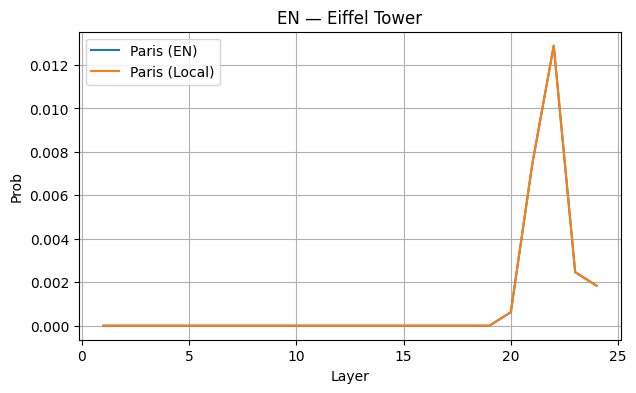


Running LogitLens: EN — Colosseum


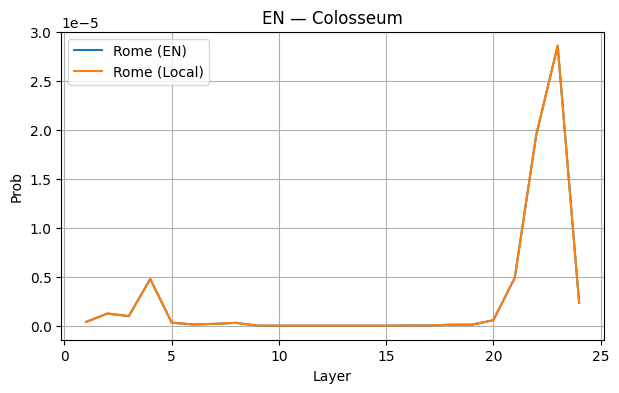


Running LogitLens: EN — Statue of Liberty


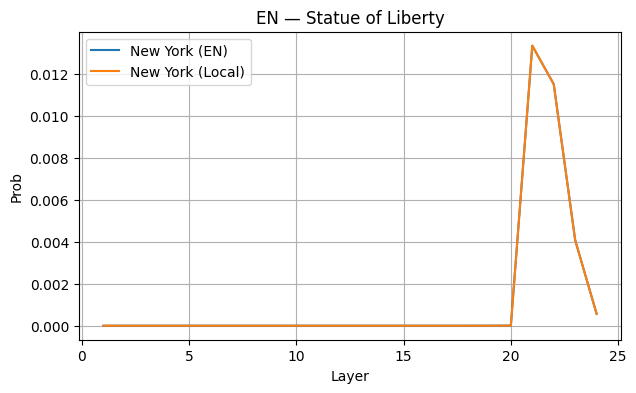


Running LogitLens: FR — Eiffel Tower


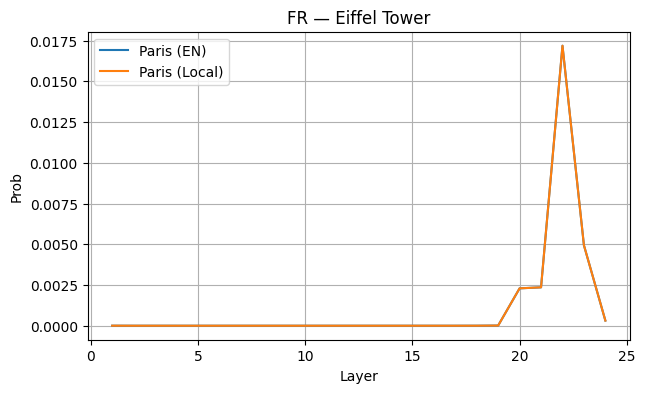


Running LogitLens: FR — Colosseum


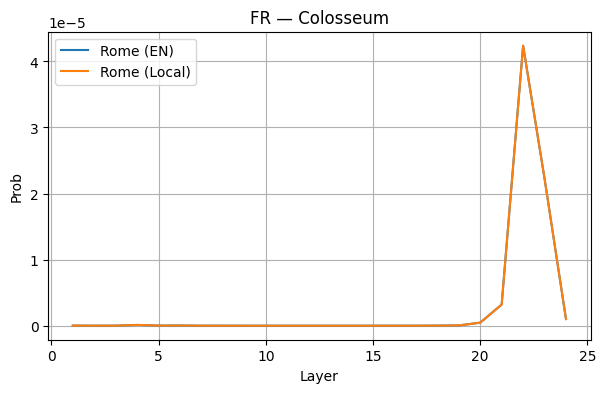


Running LogitLens: FR — Statue of Liberty


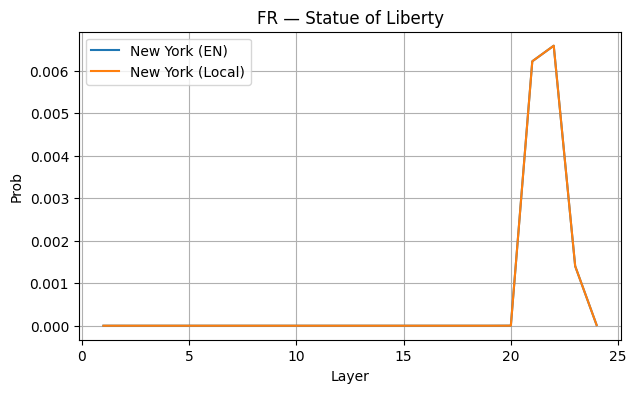


Running LogitLens: ZH — Eiffel Tower


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 24052 (\N{CJK UNIFIED IDEOGRAPH-5DF4}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 40654 (\N{CJK UNIFIED IDEOGRAPH-9ECE}) missing from font(s) DejaVu Sans.



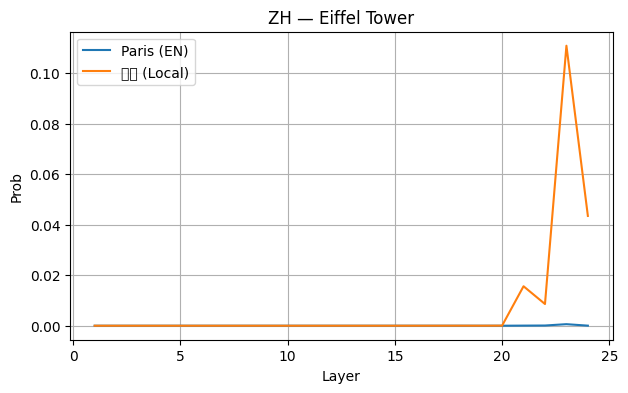


Running LogitLens: ZH — Colosseum


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 32599 (\N{CJK UNIFIED IDEOGRAPH-7F57}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 39532 (\N{CJK UNIFIED IDEOGRAPH-9A6C}) missing from font(s) DejaVu Sans.



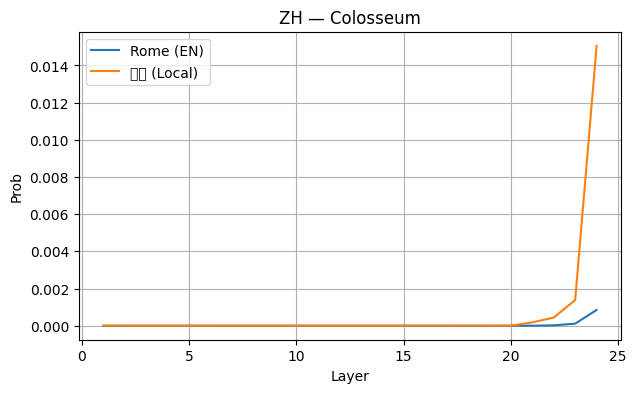


Running LogitLens: ZH — Statue of Liberty


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 32445 (\N{CJK UNIFIED IDEOGRAPH-7EBD}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 32422 (\N{CJK UNIFIED IDEOGRAPH-7EA6}) missing from font(s) DejaVu Sans.



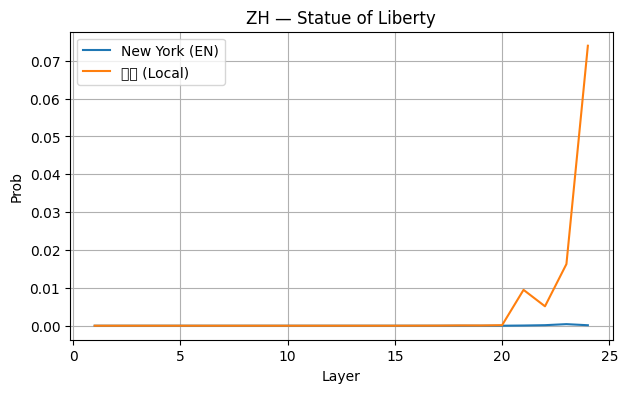


Running LogitLens: ES — Eiffel Tower


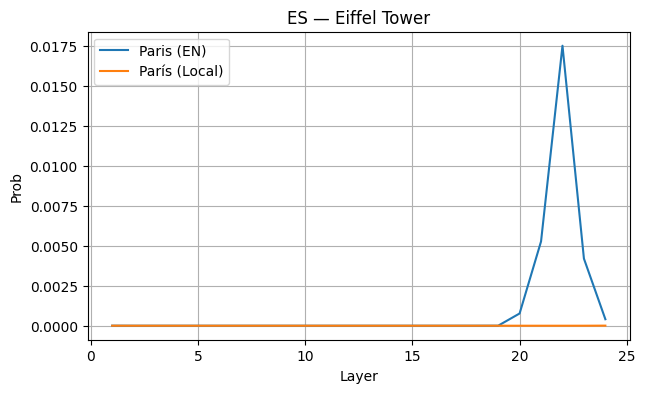


Running LogitLens: ES — Colosseum


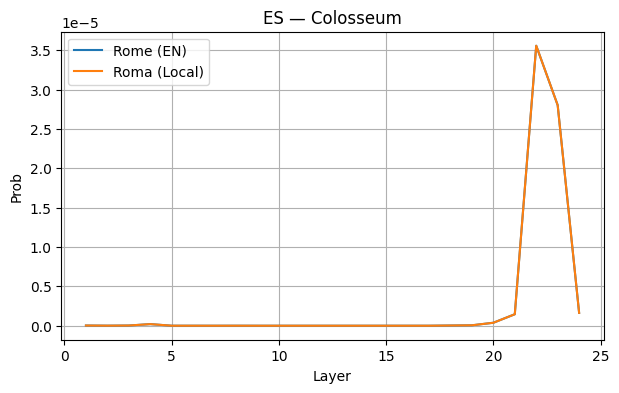


Running LogitLens: ES — Statue of Liberty


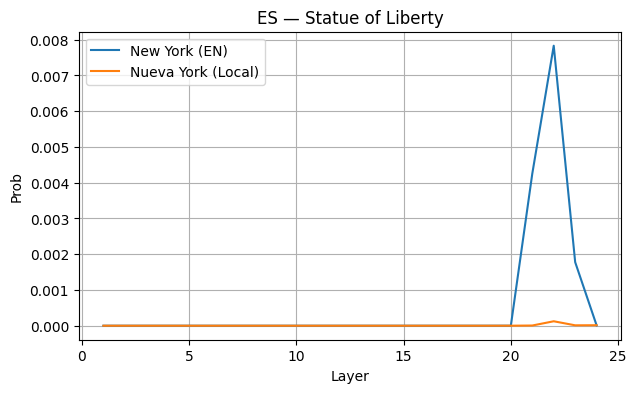

/tmp/ipython-input-1322858014.py:40: RuntimeWarning:

Mean of empty slice

/tmp/ipython-input-1322858014.py:41: RuntimeWarning:

Mean of empty slice



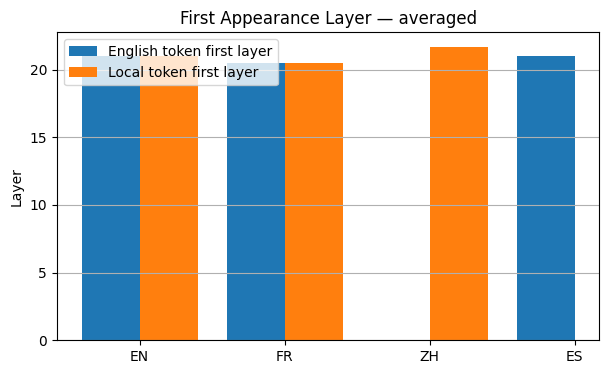

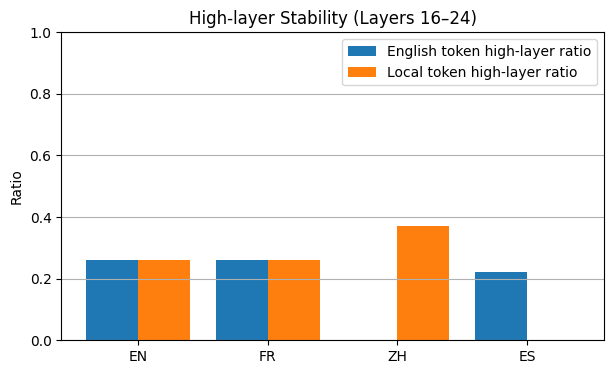

In [15]:
stats = {}   # Save the final statistical results

for lang in languages:
    stats[lang] = {"en_first": [], "local_first": [], "en_ratio": [], "local_ratio": []}

    for lm, cities in landmarks.items():

        city_en    = cities["EN"]
        city_local = cities[lang]

        prompt = templates[lang].format(lm)

        print(f"\nRunning LogitLens: {lang} — {lm}")
        results, layer_logits = run_logitlens(model, tokenizer, prompt, top_k=5, device=DEVICE)

        # token ids
        en_id = get_token_id(tokenizer, city_en)
        local_id = get_token_id(tokenizer, city_local)

        # prob curves
        en_curve = prob_curve(layer_logits, en_id)
        local_curve = prob_curve(layer_logits, local_id)

        stats[lang]["en_first"].append(first_layer(en_curve))
        stats[lang]["local_first"].append(first_layer(local_curve))
        stats[lang]["en_ratio"].append(ratio_high(en_curve))
        stats[lang]["local_ratio"].append(ratio_high(local_curve))

        layers = list(range(1, len(en_curve)+1))
        plt.figure(figsize=(7,4))
        plt.plot(layers, en_curve, label=f"{city_en} (EN)")
        plt.plot(layers, local_curve, label=f"{city_local} (Local)")
        plt.title(f"{lang} — {lm}")
        plt.xlabel("Layer"); plt.ylabel("Prob")
        plt.grid(True); plt.legend()
        plt.show()


langs = languages
en_avg = [np.nanmean(clean_list_for_nanmean(stats[l]["en_first"]))for l in langs]
loc_avg = [np.nanmean(clean_list_for_nanmean(stats[l]["local_first"]))for l in langs]

x = np.arange(len(langs))
plt.figure(figsize=(7,4))
plt.bar(x-0.2, en_avg, width=0.4, label="English token first layer")
plt.bar(x+0.2, loc_avg, width=0.4, label="Local token first layer")
plt.xticks(x, langs); plt.ylabel("Layer")
plt.title("First Appearance Layer — averaged")
plt.legend(); plt.grid(axis="y")
plt.show()


en_hr = [np.mean(stats[l]["en_ratio"]) for l in langs]
loc_hr = [np.mean(stats[l]["local_ratio"]) for l in langs]

x = np.arange(len(langs))
plt.figure(figsize=(7,4))
plt.bar(x-0.2, en_hr, width=0.4, label="English token high-layer ratio")
plt.bar(x+0.2, loc_hr, width=0.4, label="Local token high-layer ratio")
plt.xticks(x, langs); plt.ylabel("Ratio")
plt.title("High-layer Stability (Layers 16–24)")
plt.ylim(0,1); plt.legend(); plt.grid(axis="y")
plt.show()


Across all non-English prompts, Qwen1.5 consistently shows an English-first retrieval pattern:

- The English city name (e.g., Paris, Rome, New York) appears in the middle layers (≈10–18) even when the prompt is French, Chinese, or Spanish.

- The target-language token appears later, usually in higher layers (≈18–22).

- In the final layers, the model converts the English knowledge into the correct local-language answer.

These results suggest that Qwen’s internal knowledge representations are primarily stored or accessed in English, and other languages rely on high-layer translation mechanisms to produce the final output.

## Part 4: Reflection and Looking Ahead

### 4.1: Designing a Causal Test
**Goal**

Design an activation patching experiment to test when language information becomes causally important for generating a language-specific output.

 **1. How should the clean run and the corrupted run look?**

- Clean run:
    
    Use a normal English prompt, e.g.
    
    “The Eiffel Tower is in the city of”.
    
- Corrupted run:
    
    Keep the sentence in English, but inject noise inside a few words, e.g.
    
    “The Eiffel Tow3r is in the citx of”.
    
    This disrupts token-level spelling information while keeping the overall structure and semantics intact.
    

 **2. Do you use different prompts? Do you introduce noise?**

- I use same-language noisy corruption: the prompt remains in English, and only a few words are perturbed.
- This mainly breaks token-level surface forms while preserving sentence structure and meaning.
- This setup lets us focus on whether the model relies on precise token details or on abstract semantic information when predicting “Paris”.

**3. What would you patch, and at which layers?**

- I patch only the hidden state of the final token position (the position used for predicting the next word).
- At layer LLL, I replace the corrupted run’s hidden state with the clean run’s hidden state at the same position.
- I patch several representative layers such as layers 2, 6, 10, and 14, corresponding to early, middle, and late parts of the model.

**4. How would you measure whether your patching “worked”?**

- A patch “works” if, after patching layer LLL, the corrupted run’s probability or rank for *“Paris”* becomes close to the clean run and far above the unpatched corrupted run.
- If patching at a layer has little or no effect, that layer’s representation is not causally sufficient to restore the correct prediction.


### 4.2: Other Tests
We can also use linear probing to train a simple classifier on hidden states from different layers to see whether city or language information appears early. We can use sparse autoencoders to check whether specific features represent entities like Paris, and Patchscope to trace which heads or MLP units contribute to the prediction. These methods help verify whether the patterns observed with LogitLens reflect real causal structure.


### 4.3: Feedback
